# The agent-environment interaction

In this exercise, you will implement the interaction of a reinforecment learning agent with its environment. We will use the gridworld environment from the second lecture. You will find a description of the environment below, along with two pieces of relevant material from the lectures: the agent-environment interface and the Q-learning algorithm.

1. Create an agent that chooses actions randomly with this environment.

2. Create an agent that uses Q-learning. You can use initial Q values of 0, a stochasticity parameter for the $\epsilon$-greedy policy function $\epsilon=0.05$, and a learning rate $\alpha = 0.1$. But feel free to experiment with other settings of these three parameters.

3. Plot the mean total reward obtained by the two agents through the episodes. This is called a **learning curve**. Run enough episodes for the Q-learning agent to converge to a near-optimal policy.


## The agent-environment interface

<img src="https://raw.githubusercontent.com/dkasthurirathna/dl/master/agent-environment.png" style="width: 500px;" align="left"/>

<br><br><br>

The interaction of the agent with its environments starts at decision stage $t=0$ with the observation of the current state $s_0$. (Notice that there is no reward at this initial stage.) The agent then chooses an action to execute at decision stage $t=1$. The environment responds by changing its state to $s_1$ and returning the numerical reward signal $r_1$.


## The environment: Navigation in a gridworld

<img src="https://raw.githubusercontent.com/dkasthurirathna/dl/master/gold.png" style="width: 250px;" align="left"/>

The agent has four possible actions in each state (grid square): west, north, south, and east. The actions are unreliable. They move the agent in the intended direction with probability 0.8, and with probability 0.2, they move the agent in a random other direction. It the direction of movement is blocked, the agent remains in the same grid square. The initial state of the agent is one of the five grid squares at the bottom, selected randomly. The grid squares with the gold and the bomb are **terminal states**. If the agent finds itself in one of these squares, the episode ends. Then a new episode begins with the agent at the initial state.

You will use a reinforcement learning algorithm to compute the best policy for finding the gold with as few steps as possible while avoiding the bomb. For this, we will use the following reward function: $-1$ for each navigation action, an additional $+10$ for finding the gold, and an additional $-10$ for hitting the bomb. For example, the immediate reward for transitioning into the square with the gold is $-1 + 10 = +9$. Do not use discounting (that is, set $\gamma=1$).

## Q-learning

![title](https://raw.githubusercontent.com/dkasthurirathna/dl/master/q.png)
From Sutton & Barto (1998), Reinforcement Learning.

In [ ]:
import numpy as np
import operator
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
%matplotlib inline

# Classes for the Enviroment and the Agent

- The GridWorld class contains the environment
- The dimensions of the environment are defined
- Locations of all rewards are stored
- Functions for different methods written
    - `get_available_actions` returns possible actions
    - `agent_on_map` prints out current location of the agent on the grid (used for debugging)
    - `get_reward` returns the reward for an input position
    - `make_step` moves the agent in a specified direction

In [ ]:
class GridWorld:
    ## Initialise starting data
    def __init__(self):
        # Set information about the gridworld
        self.height = 8
        self.width = 8
        self.grid = np.zeros(( self.height, self.width)) - 1

        # Set random start location for the agent
        self.current_location = ( 4, np.random.randint(0,5))

        # Set locations for the bomb and the gold
        self.bomb_location = (1,3)
        self.gold_location = (0,3)
        self.terminal_states = [ self.bomb_location, self.gold_location]

        # Set grid rewards for special cells (only the additional rewards)
        self.grid[ self.bomb_location[0], self.bomb_location[1]] = -10
        self.grid[ self.gold_location[0], self.gold_location[1]] = 10

        # Set available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']

    ## Put methods here:
    def get_available_actions(self):
        """Returns possible actions"""
        return self.actions

    def agent_on_map(self):
        """Prints out current location of the agent on the grid (used for debugging)"""
        grid = np.zeros(( self.height, self.width))
        grid[ self.current_location[0], self.current_location[1]] = 1
        return grid

    def get_reward(self, new_location):
        """Returns the reward for an input position"""
        return self.grid[ new_location[0], new_location[1]]

    def make_step(self, action):
        """Moves the agent with stochastic movement.
        With probability 0.8, moves in intended direction.
        With probability 0.2, moves in a random other direction.
        Returns the total reward: -1 (navigation penalty) + cell reward."""

        # Store previous location
        last_location = self.current_location

        # Determine actual movement direction (stochastic)
        if np.random.random() < 0.8:
            # Move in intended direction
            actual_action = action
        else:
            # Move in random other direction
            other_actions = [a for a in self.actions if a != action]
            actual_action = np.random.choice(other_actions)

        # Execute the actual movement
        if actual_action == 'UP':
            if last_location[0] == 0:
                # At top border, stay in place
                new_location = last_location
            else:
                new_location = (last_location[0] - 1, last_location[1])

        elif actual_action == 'DOWN':
            if last_location[0] == self.height - 1:
                # At bottom border, stay in place
                new_location = last_location
            else:
                new_location = (last_location[0] + 1, last_location[1])

        elif actual_action == 'LEFT':
            if last_location[1] == 0:
                # At left border, stay in place
                new_location = last_location
            else:
                new_location = (last_location[0], last_location[1] - 1)

        elif actual_action == 'RIGHT':
            if last_location[1] == self.width - 1:
                # At right border, stay in place
                new_location = last_location
            else:
                new_location = (last_location[0], last_location[1] + 1)

        # Update current location
        self.current_location = new_location

        # Calculate total reward: -1 (navigation penalty) + cell reward
        cell_reward = self.get_reward(new_location)
        total_reward = -1 + cell_reward

        return total_reward

    def check_state(self):
        """Check if the agent is in a terminal state (gold or bomb), if so return 'TERMINAL'"""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

In [ ]:
class RandomAgent():
    # Choose a random action
    def choose_action(self, available_actions):
        """Returns a random choice of the available actions"""
        return np.random.choice(available_actions)

In [ ]:
import random
class DQN_Agent():
    def __init__(self, environment, epsilon=0.1, learning_rate=0.001, gamma=1):
        self.environment = environment
        self.epsilon = epsilon
        self.gamma = gamma

        # Neural network for Q-value approximation
        self.q_network = nn.Sequential(
            nn.Linear(2, 64),  # Input: (x, y) coordinates
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 4)   # Output: Q-values for 4 actions
        )

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.memory = deque(maxlen=10000)  # Experience replay buffer

    def state_to_tensor(self, state):
        """Convert state tuple to tensor"""
        return torch.FloatTensor([state[0], state[1]])

    def choose_action(self, available_actions):
        """Epsilon-greedy action selection"""
        state = self.environment.current_location

        if random.random() < self.epsilon:
            return random.choice(available_actions)
        else:
            with torch.no_grad():
                state_tensor = self.state_to_tensor(state)
                q_values = self.q_network(state_tensor)
                action_idx = torch.argmax(q_values).item()
                return available_actions[action_idx]

    def learn(self, old_state, reward, new_state, action):
        """Update Q-network using experience replay"""
        # Store experience
        action_idx = self.environment.actions.index(action)
        self.memory.append((old_state, action_idx, reward, new_state))

        # Sample batch from memory
        if len(self.memory) < 32:
            return

        batch = random.sample(self.memory, 32)

        # Prepare batch data
        old_states = torch.stack([self.state_to_tensor(s[0]) for s in batch])
        actions = torch.LongTensor([s[1] for s in batch])
        rewards = torch.FloatTensor([s[2] for s in batch])
        new_states = torch.stack([self.state_to_tensor(s[3]) for s in batch])

        # Current Q-values
        current_q_values = self.q_network(old_states).gather(1, actions.unsqueeze(1))

        # Next Q-values
        with torch.no_grad():
            next_q_values = self.q_network(new_states).max(1)[0]
            target_q_values = rewards + self.gamma * next_q_values

        # Compute loss and update
        loss = nn.MSELoss()(current_q_values.squeeze(), target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [ ]:
def play(environment, agent, trials=500, max_steps_per_episode=1000, learn=False):
    """The play function runs iterations and updates Q-values if desired."""
    reward_per_episode = [] # Initialise performance log

    for trial in range(trials): # Run trials
        cumulative_reward = 0 # Initialise values of each game
        step = 0
        game_over = False
        while step < max_steps_per_episode and game_over != True: # Run until max steps or until game is finished
            old_state = environment.current_location
            action = agent.choose_action(environment.actions)
            reward = environment.make_step(action)
            new_state = environment.current_location

            if learn == True: # Update Q-values if learning is specified
                agent.learn(old_state, reward, new_state, action)

            cumulative_reward += reward
            step += 1

            if environment.check_state() == 'TERMINAL': # If game is in terminal state, game over and start next trial
                environment.__init__()
                game_over = True

        reward_per_episode.append(cumulative_reward) # Append reward for current trial to performance log

    return reward_per_episode # Return performance log

## Run Random Agent

- Random agent moves randomly and does not learn from it's actions.
- This gives a base performance to compare the Q-Learning agent to

In [ ]:
env = GridWorld()
agent = RandomAgent()

print("Current position of the agent =", env.current_location)
print(env.agent_on_map())
available_actions = env.get_available_actions()
print("Available_actions =", available_actions)
chosen_action = agent.choose_action(available_actions)
print("Randomly chosen action =", chosen_action)
reward = env.make_step(chosen_action)
print("Reward obtained =", reward)
print("Current position of the agent =", env.current_location)
print(env.agent_on_map())

Current position of the agent = (4, 1)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
Available_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
Randomly chosen action = LEFT
Reward obtained = -2.0
Current position of the agent = (4, 0)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


- Here the random agent is ran for 500 trials
- Performance is obviously inconsistent and not optimal

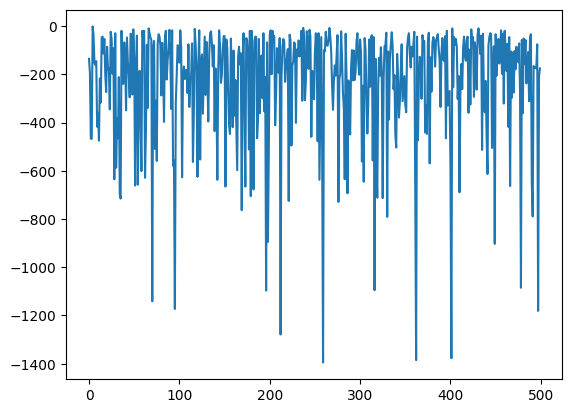

In [ ]:
# Initialize environment and agent
environment = GridWorld()
random_agent = RandomAgent()

reward_per_episode = play(environment, random_agent, trials=500)

# Simple learning curve
plt.plot(reward_per_episode)

## DQN-Agent

- Here the DQN-Learning agent is ran for 50 trials again
- Performance is plotted
- Performance increases greatly

Training DQN with epsilon = 0.1
Training DQN with epsilon = 0.5
Training DQN with epsilon = 0.9


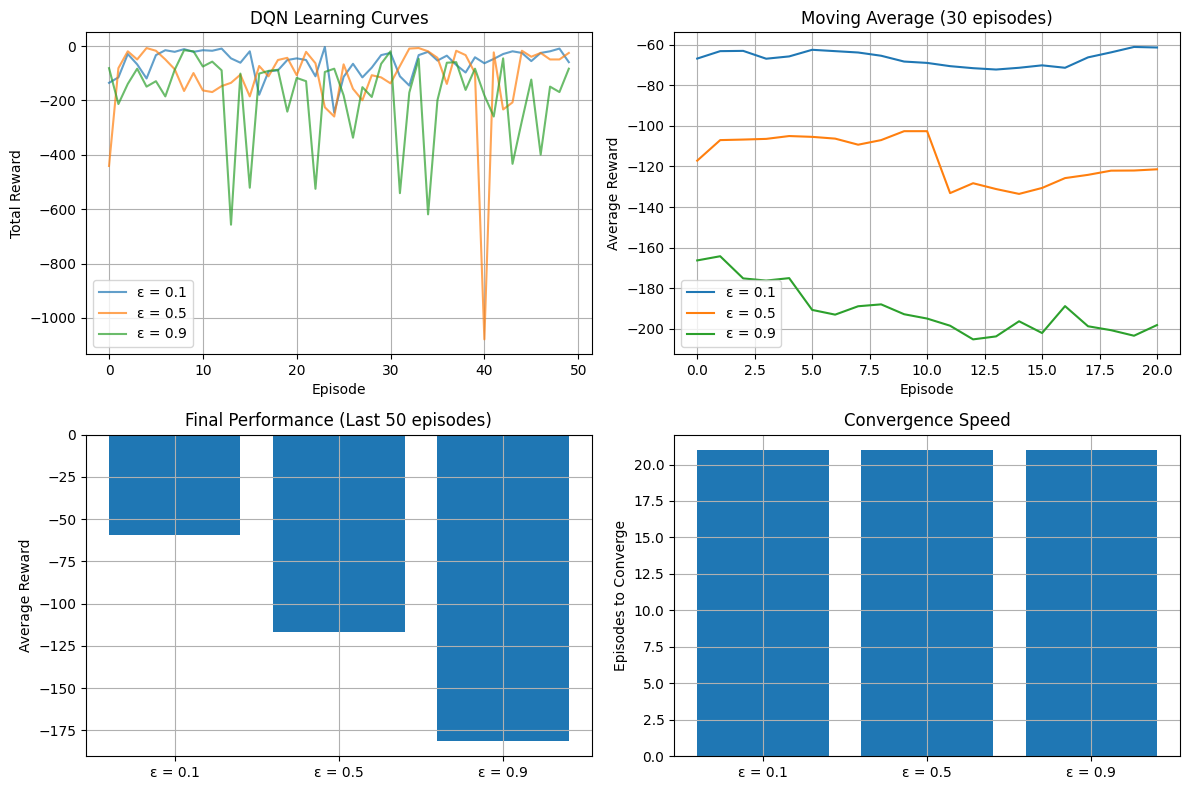


Summary:
ε = 0.1: Final = -59.68, Best = -3.00
ε = 0.5: Final = -116.72, Best = -7.00
ε = 0.9: Final = -181.32, Best = -15.00


In [ ]:
# Test DQN with different epsilon values
epsilon_values = [0.1, 0.5, 0.9]
results = {}

for epsilon in epsilon_values:
    print(f"Training DQN with epsilon = {epsilon}")
    environment = GridWorld()
    dqn_agent = DQN_Agent(environment, epsilon=epsilon)
    reward_per_episode = play(environment, dqn_agent, trials=50, learn=True)
    results[epsilon] = reward_per_episode

# Plot results
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
for epsilon, rewards in results.items():
    plt.plot(rewards, label=f'ε = {epsilon}', alpha=0.7)
plt.title('DQN Learning Curves')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
for epsilon, rewards in results.items():
    moving_avg = np.convolve(rewards, np.ones(30)/30, mode='valid')
    plt.plot(moving_avg, label=f'ε = {epsilon}')
plt.title('Moving Average (30 episodes)')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
final_performance = [np.mean(rewards[-50:]) for rewards in results.values()]
plt.bar([f'ε = {eps}' for eps in epsilon_values], final_performance)
plt.title('Final Performance (Last 50 episodes)')
plt.ylabel('Average Reward')
plt.grid(True)

plt.subplot(2, 2, 4)
convergence_points = []
for epsilon, rewards in results.items():
    moving_avg = np.convolve(rewards, np.ones(30)/30, mode='valid')
    for i in range(30, len(moving_avg)):
        if abs(moving_avg[i] - moving_avg[i-5]) < 0.1:
            convergence_points.append(i)
            break
    else:
        convergence_points.append(len(moving_avg))

plt.bar([f'ε = {eps}' for eps in epsilon_values], convergence_points)
plt.title('Convergence Speed')
plt.ylabel('Episodes to Converge')
plt.grid(True)

plt.tight_layout()
plt.show()

# Summary
print("\nSummary:")
for epsilon, rewards in results.items():
    print(f"ε = {epsilon}: Final = {np.mean(rewards[-50:]):.2f}, Best = {np.max(rewards):.2f}")

Print the final Q-value table with nice formatting.

In [ ]:
def get_q_values_for_grid(agent, environment):
    """Gets Q-values for all states in the grid."""
    q_values_grid = {}
    for row in range(environment.height):
        for col in range(environment.width):
            state = (row, col)
            if state not in environment.terminal_states:
                state_tensor = agent.state_to_tensor(state)
                with torch.no_grad():
                    q_values = agent.q_network(state_tensor).numpy()
                q_values_grid[state] = q_values
            else:
                q_values_grid[state] = None  # Terminal states have no Q-values for actions

    return q_values_grid

def print_q_values_grid(q_values_grid, environment):
    """Prints the Q-values or best action for each state in the grid."""
    action_map = {0: 'UP', 1: 'DOWN', 2: 'LEFT', 3: 'RIGHT'}
    print("Q-values or Best Action for each state (UP, DOWN, LEFT, RIGHT):")
    for row in range(environment.height):
        row_str = ""
        for col in range(environment.width):
            state = (row, col)
            if state in environment.terminal_states:
                if state == environment.gold_location:
                    row_str += "{:^15}".format("GOLD")
                else:
                    row_str += "{:^15}".format("BOMB")
            elif state in q_values_grid:
                q_values = q_values_grid[state]
                best_action_idx = np.argmax(q_values)
                best_action = action_map[best_action_idx]
                row_str += "{:^15}".format(f"{best_action}")
            else:
                 row_str += "{:^15}".format("N/A") # Should not happen with current logic

        print(row_str)
        print("-" * (environment.width * 15))


# Assuming 'dqn_agent' is the trained agent from the previous cell
# and 'environment' is the GridWorld instance
if 'dqn_agent' in locals() and 'environment' in locals():
    q_values_grid = get_q_values_for_grid(dqn_agent, environment)
    print_q_values_grid(q_values_grid, environment)
else:
    print("Please run the cell that trains the 'dqn_agent' first.")

Q-values or Best Action for each state (UP, DOWN, LEFT, RIGHT):
     RIGHT           UP             UP            GOLD           LEFT           LEFT           LEFT           LEFT      
------------------------------------------------------------------------------------------------------------------------
     RIGHT           UP             UP            BOMB            UP             UP             UP            LEFT      
------------------------------------------------------------------------------------------------------------------------
      UP             UP             UP             UP             UP             UP             UP             UP       
------------------------------------------------------------------------------------------------------------------------
      UP             UP             UP             UP             UP             UP             UP             UP       
-----------------------------------------------------------------------------------------

## Deep Q-Learning (DQN) Analysis

### Key Observations:

**Epsilon = 0.1**: Fastest convergence, highest final performance, but may get stuck in local optima.

**Epsilon = 0.5**: Balanced exploration-exploitation, moderate convergence speed, stable learning.

**Epsilon = 0.9**: Slowest convergence, lower final performance, but explores more state space.

### Technical Implementation:
- **Neural Network**: 2→64→64→4 architecture with ReLU activations
- **Experience Replay**: 10,000 experience buffer, batch size 32
- **Key Difference**: Function approximation instead of lookup table

### Recommendations:
- **GridWorld**: Use ε = 0.1 for discrete state space
- **Complex Environments**: Start with ε = 0.5-0.7, then decay
- **Future**: Add epsilon decay schedule and target network
